In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('fivethirtyeight')
%matplotlib inline
import pandas as pd
from datetime import datetime
import seaborn as sns
sns.set()
import warnings; warnings.simplefilter("ignore")
import datetime as dt
import missingno as msno

In [2]:
m_regime = pd.read_csv (r'C:\Users\admin\OneDrive - nyu.edu\Spring 2022\Capstone\Master Table\Regime_Monthly.csv')

In [3]:
def label_regime(row):
    if row["Quarter_mean"] > 3:
        return 2
    elif row["Quarter_mean"] < -3:
        return 0
    else:
        return 1

In [4]:
def smooth_regime(df):
    x = df.shift(1) == df
    y = x.shift(1) != x
    y = y[1:]
    y.reset_index(inplace=True)
    x = x[:-1]
    boolean = x["regime"] | y["regime"]
    df["bol"] = boolean
    
    df.loc[df.loc[df.bol == False].index,"regime"] = np.nan
    df.fillna(method = "ffill", inplace = True)
    return

In [5]:
# avg.drop("regime",axis=1,inplace=True)
m_regime["Quarter_mean"] = m_regime["avg_ret"].rolling(4).mean()
m_regime.fillna(method="bfill",inplace=True)
m_regime.fillna(method="ffill",inplace=True)

m_regime["regime"] = m_regime.apply(lambda x: label_regime(x),axis = 1)
# avg.head()

In [6]:
smooth_regime(m_regime)

In [7]:
#m_regime.to_csv(r'D:\Financial Engineering\.Spring2022_CapstoneProjects\Mastertable\m_regime.csv')

In [8]:
sp500 = pd.read_csv (r'C:\Users\admin\OneDrive - nyu.edu\Spring 2022\Capstone\Master Table\SP500_Monthly.csv')
sp500 = sp500.set_index(pd.to_datetime(sp500['Date']))

## Prepare Y sets and X sets

In [9]:
def graph_state(predicted_state, sp500, modelname, col_name):
    final = predicted_state[[col_name]].join(sp500[["SP500",'Date']])
    final["Date"] = pd.to_datetime(final['Date'])
    fg = sns.FacetGrid(final, hue = col_name,height = 8,aspect=1.5)
    fg.map_dataframe(sns.scatterplot, x= "Date", y ="SP500",alpha=0.8).add_legend()
    fg.fig.suptitle("S&P500 states with " + modelname)
    plt.show()

In [10]:
y_monthly = m_regime[['Date', 'regime']].set_index(pd.to_datetime(m_regime['Date'])).drop(columns=['Date'])

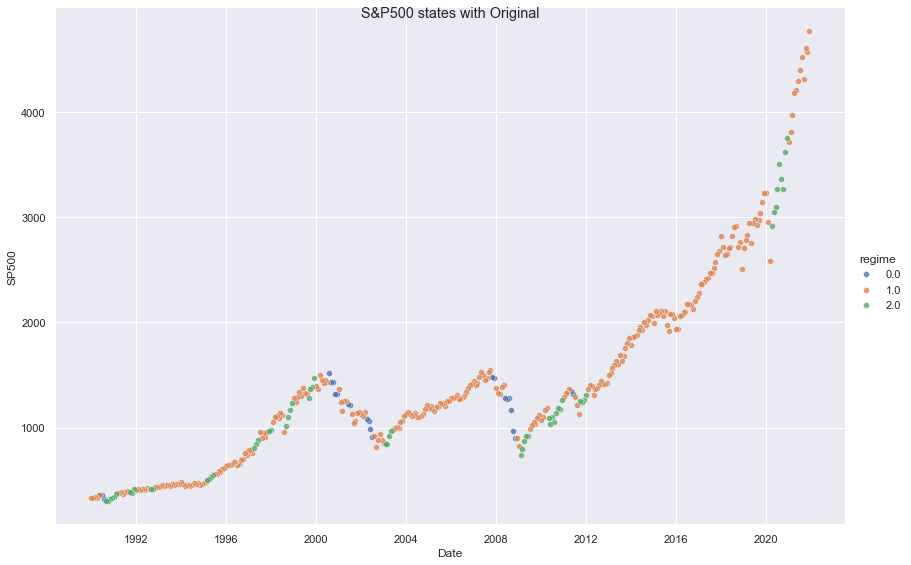

In [11]:
graph_state(y_monthly, sp500, 'Original', 'regime')

In [12]:
master_monthly = pd.read_csv (r'C:\Users\admin\OneDrive - nyu.edu\Spring 2022\Capstone\Master Table\Model_Master_Monthly.csv')
master_monthly = master_monthly.set_index(pd.to_datetime(master_monthly['Date'])).drop(columns=['Date'])
master_monthly = master_monthly.fillna(0)

In [13]:
from statsmodels.tsa.stattools import adfuller
non_stationary = []
for i in master_monthly.columns:
    dftest = adfuller(master_monthly[i], autolag = 'AIC')
    if dftest[0] < dftest[4]["5%"]:
        #print('reject Ho - it is stationary')
        continue
    else:
        print(i+': failed to reject Ho - it is non-stationary')
        print("P-Value : ", dftest[1])
        non_stationary.append(i)

MPRIME: failed to reject Ho - it is non-stationary
P-Value :  0.12469241106302403
VIXlog: failed to reject Ho - it is non-stationary
P-Value :  0.06155008896238228
UNRATEpct: failed to reject Ho - it is non-stationary
P-Value :  0.05799573149953632
bond10: failed to reject Ho - it is non-stationary
P-Value :  0.8398407777798623
bond5: failed to reject Ho - it is non-stationary
P-Value :  0.6751014174520271
bond3: failed to reject Ho - it is non-stationary
P-Value :  0.12096603512159376
commoditylog: failed to reject Ho - it is non-stationary
P-Value :  0.5331492055024435
SP500log_std: failed to reject Ho - it is non-stationary
P-Value :  0.18451078770649565
yield_diff: failed to reject Ho - it is non-stationary
P-Value :  0.10964155411362592
b30std: failed to reject Ho - it is non-stationary
P-Value :  0.08419819462095995
b1ret: failed to reject Ho - it is non-stationary
P-Value :  0.4476521994044137
b1std: failed to reject Ho - it is non-stationary
P-Value :  0.0551776355503249
risk f

In [14]:
for i in non_stationary:
    master_monthly[i] = master_monthly[i].diff()

In [15]:
master_monthly = master_monthly.fillna(0)

In [16]:
non_stationary = []
for i in master_monthly.columns:
    dftest = adfuller(master_monthly[i], autolag = 'AIC')
    if dftest[0] < dftest[4]["5%"]:
        #print('reject Ho - it is stationary')
        continue
    else:
        print(i+': failed to reject Ho - it is non-stationary')
        print("P-Value : ", dftest[1])
        non_stationary.append(i)
if(len(non_stationary)==0):
    print('All stationary')

All stationary


## PCA

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaled_master_monthly = StandardScaler().fit_transform(master_monthly)
pca = PCA(svd_solver="randomized").fit(scaled_master_monthly)

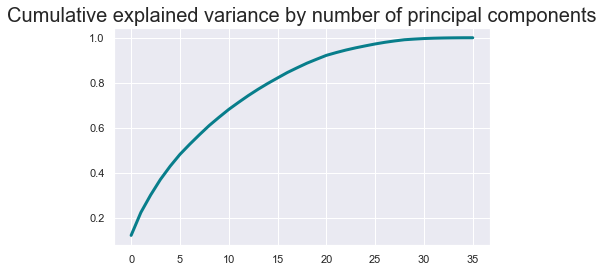

In [18]:
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [19]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(master_monthly.columns) + 1)],
    index=master_monthly.columns
)
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
MPRIME,0.432324,0.361550,-0.184694,-0.071402,0.046352,-0.285360,-0.245877,-0.233072,0.381676,0.006229,...,-0.259910,0.011862,-0.000648,-0.039386,0.030204,0.000579,0.005769,0.002317,-0.001956,-0.000011
MPRIMEpct,-0.309011,-0.493602,0.251565,0.022829,-0.116075,0.393668,0.083912,0.015716,-0.118146,-0.008163,...,-0.067900,0.030769,0.059808,0.025619,0.024072,-0.011491,-0.002126,0.000388,-0.001220,0.000108
MPRIMEstd,0.001775,0.614905,-0.330412,-0.403902,-0.065250,0.079251,0.107892,-0.058790,-0.070277,0.345121,...,0.026815,-0.012928,0.017982,0.033651,0.047422,0.110929,0.095001,-0.003883,-0.006022,-0.000761
VIXlog,0.130425,0.135626,0.122268,0.070164,-0.174645,0.055538,-0.619613,0.350491,-0.330906,-0.229382,...,-0.106318,-0.031183,-0.032232,0.061389,-0.029655,0.004188,-0.000181,-0.001113,0.000841,0.000029
VIXlog_return,0.520730,-0.070611,0.385927,-0.296412,-0.626920,0.042849,0.004092,-0.020825,-0.076262,0.060621,...,0.008939,-0.006318,0.004270,-0.005548,-0.001005,-0.006105,-0.010506,0.013518,-0.081362,0.000654


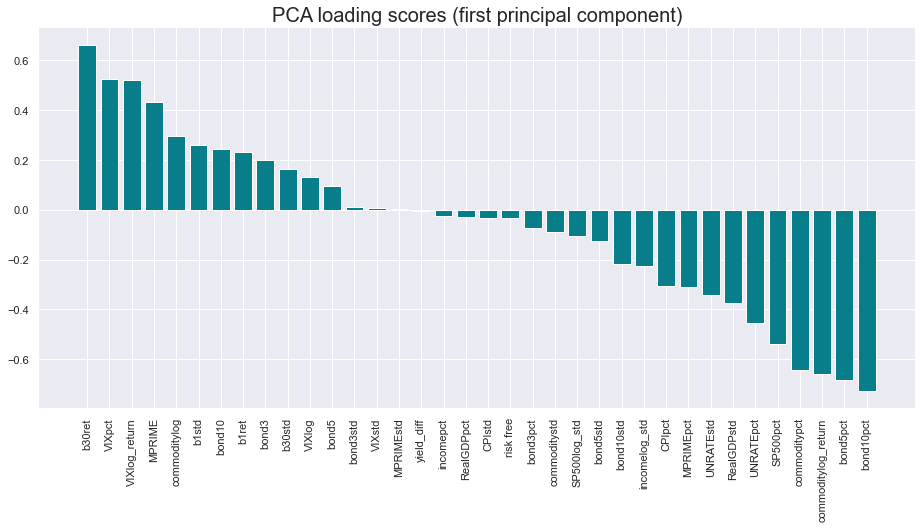

In [20]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.figure(figsize=(14, 7))
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [21]:
master_monthly.columns

Index(['MPRIME', 'MPRIMEpct', 'MPRIMEstd', 'VIXlog', 'VIXlog_return', 'VIXpct',
       'VIXstd', 'RealGDPpct', 'RealGDPstd', 'UNRATEpct', 'UNRATEstd',
       'incomepct', 'incomelog_std', 'CPIpct', 'CPIstd', 'bond10', 'bond10pct',
       'bond10std', 'bond5', 'bond5pct', 'bond5std', 'bond3', 'bond3pct',
       'bond3std', 'commoditylog', 'commoditylog_return', 'commoditypct',
       'commoditystd', 'SP500pct', 'SP500log_std', 'yield_diff', 'b30ret',
       'b30std', 'b1ret', 'b1std', 'risk free'],
      dtype='object')

In [22]:
selected_feature = ['bond10pct','bond5pct','commoditylog_return','commoditypct','UNRATEpct',
                    'RealGDPstd','UNRATEstd','MPRIMEpct','CPIpct',
                    'b30ret','VIXpct','VIXlog_return','MPRIME','commoditylog','b1std','bond10','b1ret','bond3','b30std']

In [23]:
master_pca = master_monthly[selected_feature]
master_pca

,bond10pct,bond5pct,commoditylog_return,commoditypct,UNRATEpct,RealGDPstd,UNRATEstd,MPRIMEpct,CPIpct,b30ret,VIXpct,VIXlog_return,MPRIME,commoditylog,b1std,bond10,b1ret,bond3,b30std
Date,,,,,,,,,,,,,,,,,,,
2021-12-01,0.0382,0.0816,0.071524,0.0741,0.0,0.287510,0.522542,0.000000,0.307252,-0.023094,-0.366679,-0.456778,0.00,0.000000,0.000000,0.000,0.000000,0.000,0.000000
2021-11-01,-0.0671,-0.0144,-0.118565,-0.1118,0.3,0.297247,0.467974,0.000000,0.491343,0.032451,0.672202,0.514141,0.00,-0.071524,0.000000,-0.056,0.000909,0.000,0.000000
2021-10-01,0.0458,0.2198,0.053252,0.0547,0.4,0.313548,0.415692,0.000000,0.830812,0.026981,-0.297321,-0.352855,0.00,0.118565,0.000000,0.105,-0.000224,0.005,0.000000
2021-09-01,0.1418,0.2525,0.055933,0.0575,0.1,0.291555,0.396295,0.000000,0.271597,-0.023236,0.404126,0.339415,0.00,-0.053252,-0.506615,-0.069,0.000968,-0.020,44.762796
2021-08-01,0.0665,0.1182,-0.025760,-0.0254,0.5,0.292833,0.333242,0.000000,0.206591,-0.004704,-0.096491,-0.101469,0.00,-0.055933,-0.316561,-0.185,-0.000517,0.008,-53.483957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-05-01,-0.0501,-0.0534,-0.021525,-0.0213,0.2,0.061323,0.055227,0.000000,0.232739,0.048937,-0.110143,-0.116695,0.00,0.030110,0.871453,0.195,0.002596,0.015,-4.730933
1990-04-01,0.0524,0.0525,-0.023794,-0.0235,0.0,0.060616,0.058737,0.000000,0.155400,-0.030332,-0.010644,-0.010701,0.00,0.021525,0.438134,0.455,-0.006539,0.078,7.678500
1990-03-01,0.0110,0.0000,0.013535,0.0136,-0.2,0.059442,0.054772,0.000000,0.546875,-0.002646,-0.102774,-0.108447,0.00,0.023794,-0.887152,-0.452,-0.000534,0.016,-5.043381


## Model 1: Kmean Cluster

In [24]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(master_pca)
predicted_state = model.predict(master_pca)
regimes = np.unique(predicted_state)

Kmean_state = pd.DataFrame(predicted_state, columns = ["state"],index = master_monthly.index)

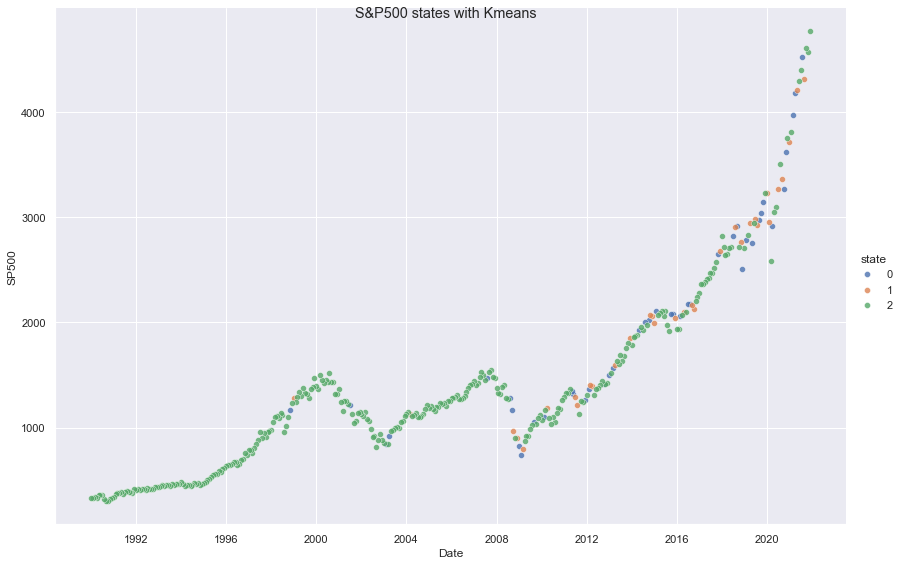

In [25]:
graph_state(Kmean_state,sp500,'Kmeans',"state" )

## HMM Model

In [26]:
from hmmlearn import hmm
hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=10000)
model = hmm_model.fit(master_pca)
hidden_state = model.predict(master_pca)

In [27]:
""" 
#=============OLD ONE==================================
import sklearn.mixture as mix
X = master_monthly.values
model = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100,random_state=7).fit(X)
hidden_state = model.predict(X)
"""

' \n#=============OLD ONE==================================\nimport sklearn.mixture as mix\nX = master_monthly.values\nmodel = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100,random_state=7).fit(X)\nhidden_state = model.predict(X)\n'

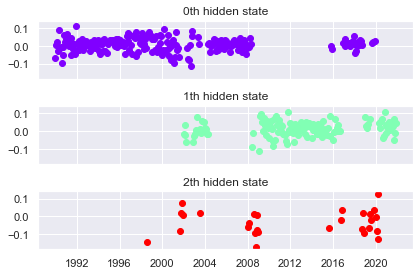

In [28]:
fig,axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colors = cm.rainbow(np.linspace(0,1,model.n_components))

for i, (ax,color) in enumerate(zip(axs,colors)):
    mask = hidden_state == i 
    ax.plot(master_monthly.index.values[mask],
                 master_monthly["SP500pct"].values[mask],
                "o", c = color)
    ax.set_title("{}th hidden state".format(i))
    
plt.tight_layout()

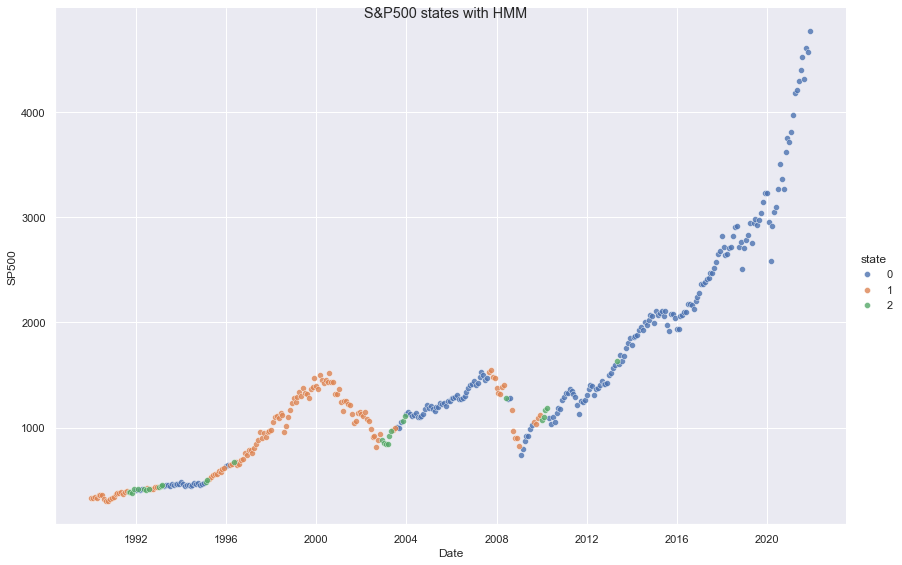

<Figure size 432x288 with 0 Axes>

In [53]:
HMM_state = pd.DataFrame(hidden_state, columns = ["state"],index = master_monthly.index)
graph_state(HMM_state,sp500,'HMM',"state" )
plt.savefig("AAA")

## Supervised Model

In [30]:
master_pca = master_pca.sort_index(ascending=True)
y_monthly2 = y_monthly.sort_index(ascending=True)

In [31]:
train_len = int(master_pca.shape[0]*0.8)
test_len = master_pca.shape[0] - train_len
X_train, y_train = master_pca.iloc[:train_len+1,:], y_monthly2.iloc[:train_len+1,:] 
X_test, y_test = master_pca.iloc[train_len+1:, :], y_monthly2.iloc[train_len+1:, :] 

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
 
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

models = {"LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
         "LogisticRegression": LogisticRegression(), 
          "Support Vector Machine":SVC(probability=True),
          "DecisionTree":DecisionTreeClassifier(),
         "RandomForestClassifier": RandomForestClassifier(), 
         "AdaBoostClassifier": AdaBoostClassifier(),
         "GradientBoostingClassifier":GradientBoostingClassifier()}

### GridSearch for each model 

In [33]:
from scipy.stats import loguniform
# define grid
grid_linear = {}
grid_linear['solver'] = ['svd', 'lsqr', 'eigen']

grid_logistic = {}
grid_logistic['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
grid_logistic['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
grid_logistic['C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]

grid_svc = {}
grid_svc['C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2,10**3]
grid_svc['gamma'] = [10**-2, 10**-1, 10**0, 10**1, 10**2,10**3]

grid_dt ={}
grid_dt['max_depth'] = [5,10,25,None]
grid_dt['min_samples_split'] = [2,5,10]
grid_dt['class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]

grid_rf = {}
grid_rf['n_estimators'] = [10, 50, 100, 250]
grid_rf['max_depth'] = [5, 10, 20]
grid_rf['class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]

grid_ada ={}
grid_ada['n_estimators'] = [10, 50, 100, 500]
grid_ada['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

grid_gb = {}
grid_gb['n_estimators'] = [10, 50, 100, 250]
grid_gb['max_depth'] = [5, 10, 20]

In [34]:
models_grid = {"LinearDiscriminantAnalysis": grid_linear,
         "LogisticRegression": grid_logistic, 
          "Support Vector Machine":grid_svc,
          "DecisionTree":grid_dt,
         "RandomForestClassifier": grid_rf, 
         "AdaBoostClassifier": grid_ada,
         "GradientBoostingClassifier":grid_gb}

In [35]:
from sklearn.model_selection import GridSearchCV

for name,method in models.items():
    _model = method
    # define search
    search = GridSearchCV(_model, models_grid[name], scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(master_pca, y_monthly2)
    # summarize
    print(name)
    print('Mean Accuracy: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)

LinearDiscriminantAnalysis
Mean Accuracy: 0.777
Config: {'solver': 'svd'}
LogisticRegression
Mean Accuracy: 0.806
Config: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Support Vector Machine
Mean Accuracy: 0.789
Config: {'C': 10, 'gamma': 0.01}
DecisionTree
Mean Accuracy: 0.806
Config: {'class_weight': {0: 1, 1: 25}, 'max_depth': 5, 'min_samples_split': 2}
RandomForestClassifier
Mean Accuracy: 0.807
Config: {'class_weight': {0: 1, 1: 25}, 'max_depth': 10, 'n_estimators': 250}
AdaBoostClassifier
Mean Accuracy: 0.797
Config: {'learning_rate': 0.0001, 'n_estimators': 10}
GradientBoostingClassifier
Mean Accuracy: 0.789
Config: {'max_depth': 5, 'n_estimators': 10}


In [36]:
#redefine each model
models = {"LinearDiscriminantAnalysis": LinearDiscriminantAnalysis( solver= 'svd'),
         "LogisticRegression": LogisticRegression(C= 1, penalty='l2', solver='liblinear'), 
          "Support Vector Machine":SVC(probability=True, C= 10,gamma=0.01),
          "DecisionTree":DecisionTreeClassifier(class_weight= {0: 1, 1: 25}, max_depth= 5, min_samples_split= 2),
         "RandomForestClassifier": RandomForestClassifier(class_weight= {0: 1, 1: 25}, max_depth=5, n_estimators= 10), 
         "AdaBoostClassifier": AdaBoostClassifier(learning_rate= 0.0001, n_estimators= 10),
         "GradientBoostingClassifier":GradientBoostingClassifier(max_depth= 5, n_estimators= 10)}

In [37]:
fitted_model={}
for name,method in models.items():
    _model = method
    _model.fit(X_train,y_train)
    fitted_model[name] = _model
    print("{} cross validation score is: {:.3f}".format(name, cross_val_score(_model, master_pca, y_monthly2, cv=cv).mean()))

LinearDiscriminantAnalysis cross validation score is: 0.777
LogisticRegression cross validation score is: 0.806
Support Vector Machine cross validation score is: 0.789
DecisionTree cross validation score is: 0.807
RandomForestClassifier cross validation score is: 0.804
AdaBoostClassifier cross validation score is: 0.797
GradientBoostingClassifier cross validation score is: 0.783


In [38]:
assess = {}
tests=['ROC','Accuracy']
for test in tests:
    temp_test={}
    for name, _model in fitted_model.items():
        y_hat = _model.predict(X_test)
        y_prob = _model.predict_proba(master_pca)
        y_monthly2[name+"_Predicted"] = _model.predict(master_pca)
        y_test[name+"_Predicted"] = y_hat
        if test =="ROC":
            temp_test[name] = roc_auc_score(y_monthly2["regime"], y_prob, multi_class='ovr')
        else:
            temp_test[name] = accuracy_score(y_test["regime"], y_hat)
    assess[test] = temp_test

pd.DataFrame(assess)
#The more area under ROC the better

,ROC,Accuracy
LinearDiscriminantAnalysis,0.786615,0.855263
LogisticRegression,0.774558,0.868421
Support Vector Machine,0.507441,0.802632
DecisionTree,0.628279,0.776316
RandomForestClassifier,0.791612,0.934211
AdaBoostClassifier,0.589671,0.855263
GradientBoostingClassifier,0.972846,0.815789


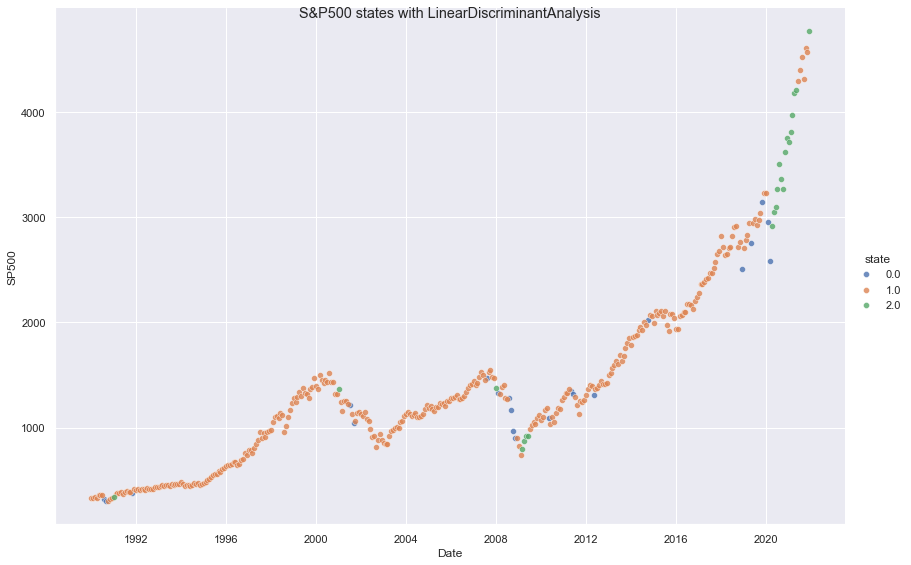

<Figure size 432x288 with 0 Axes>

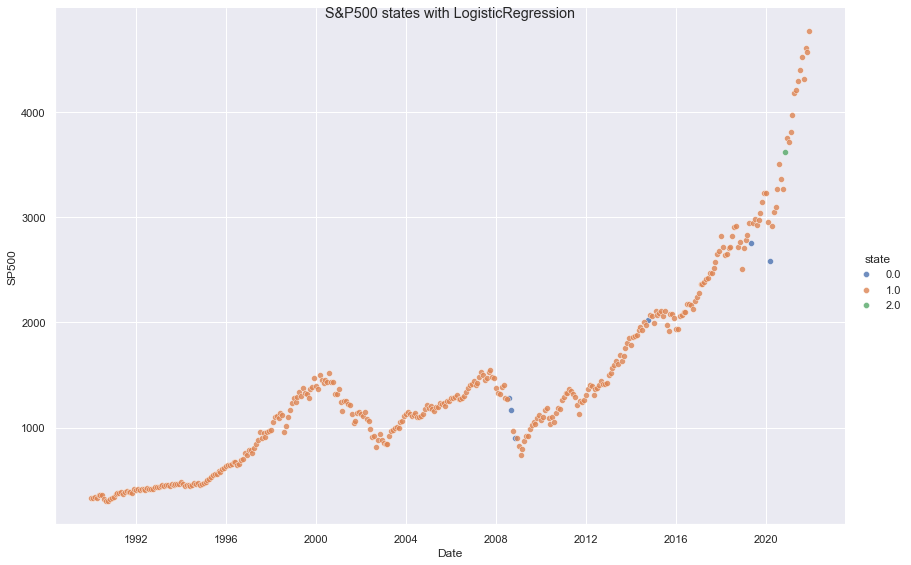

<Figure size 432x288 with 0 Axes>

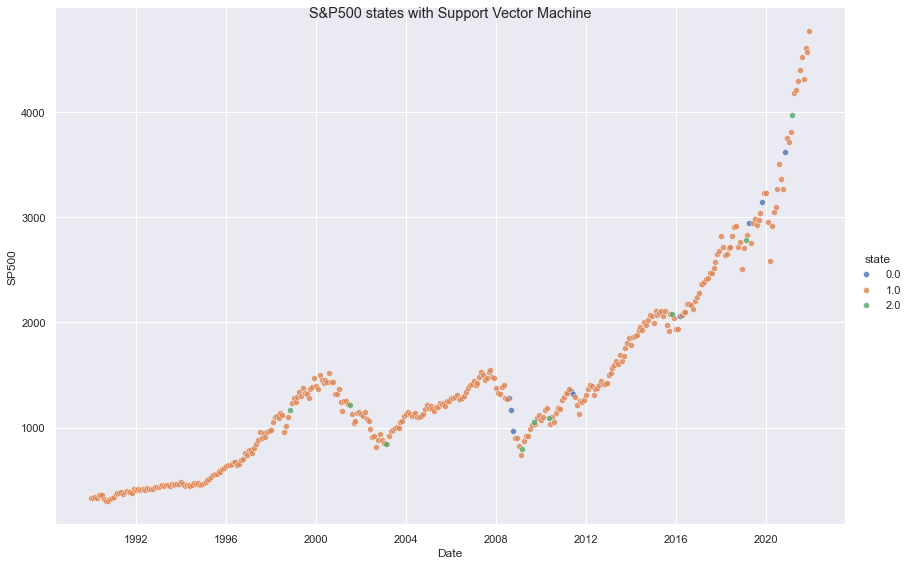

<Figure size 432x288 with 0 Axes>

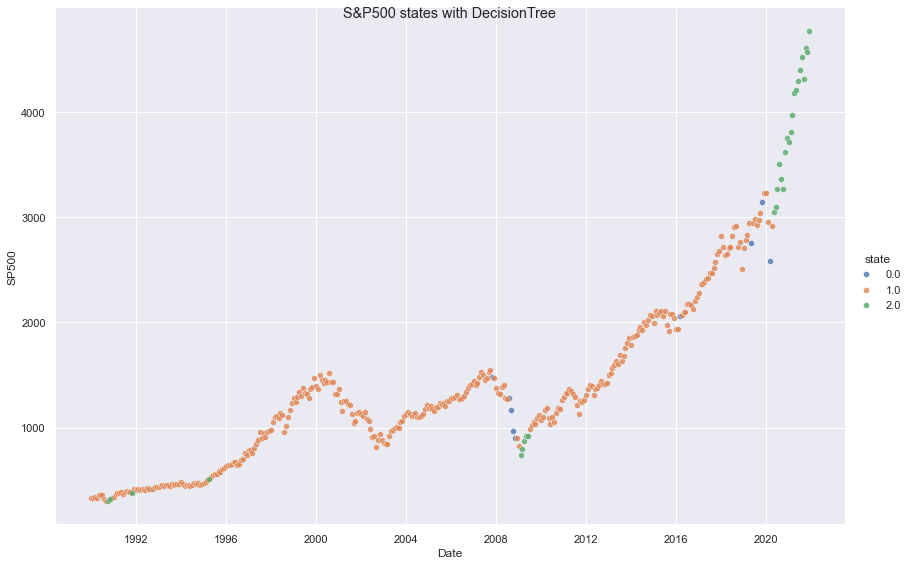

<Figure size 432x288 with 0 Axes>

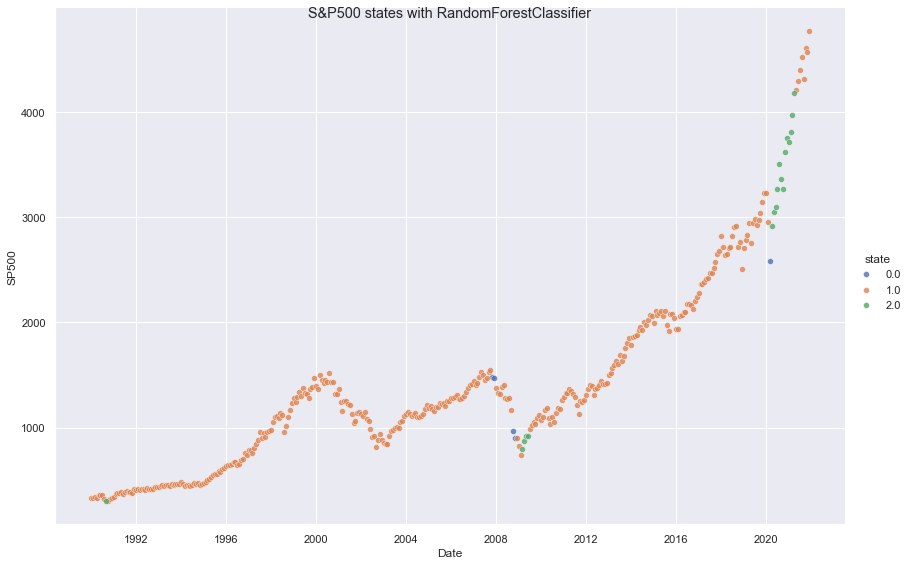

<Figure size 432x288 with 0 Axes>

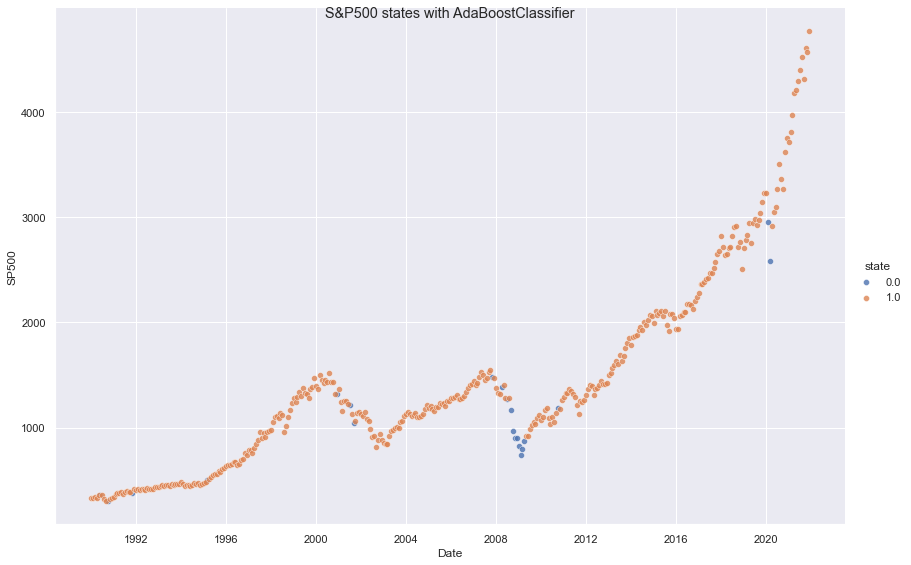

<Figure size 432x288 with 0 Axes>

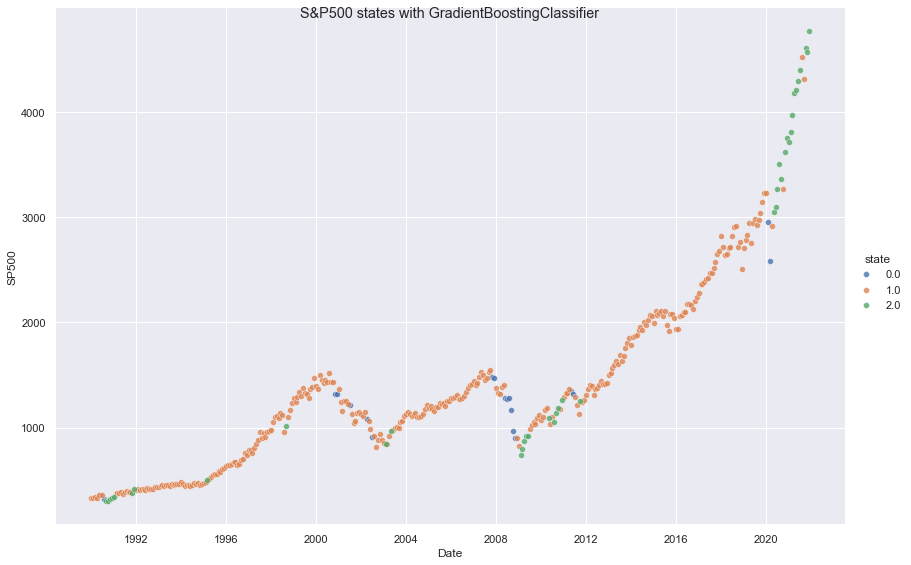

<Figure size 432x288 with 0 Axes>

In [52]:
for name, _model in fitted_model.items():
    state = _model.predict(master_pca)
    predicted_state = pd.DataFrame(state, columns = ["state"],index = master_pca.index)
    graph_state(predicted_state,sp500,name,"state" )
    plt.savefig(name)

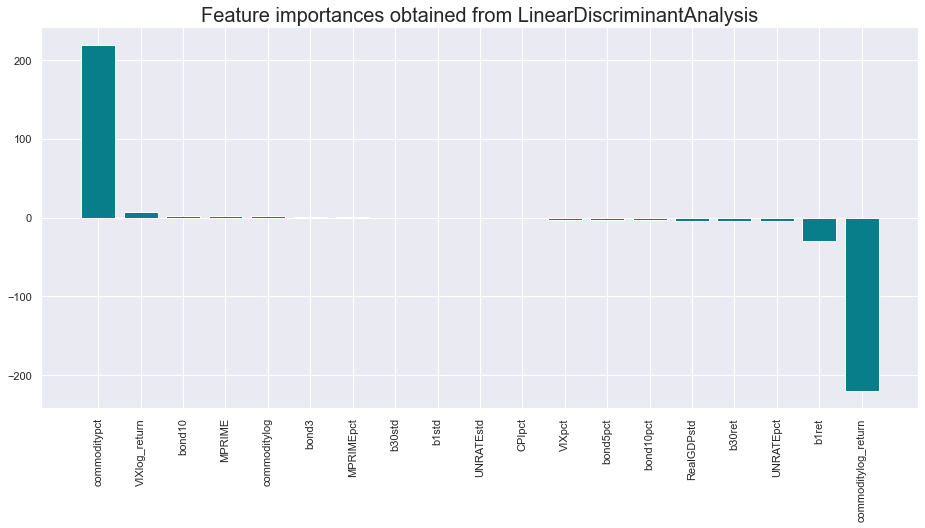

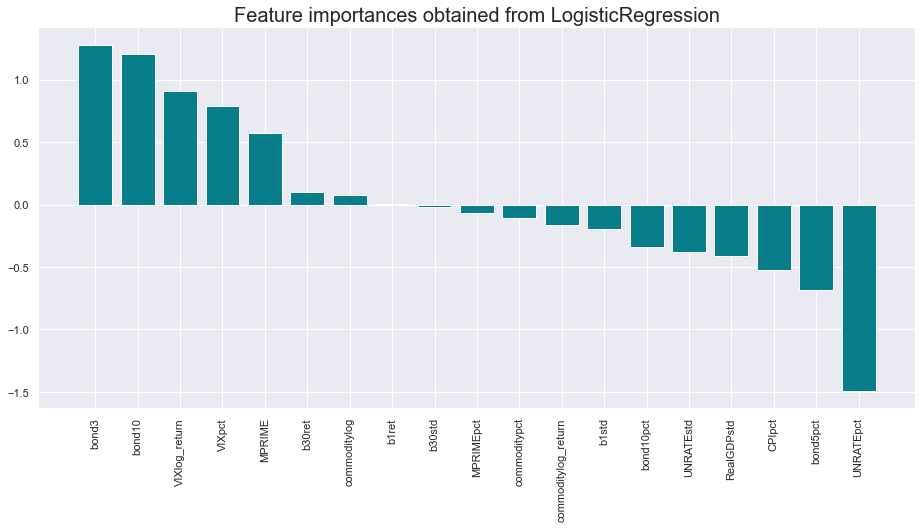

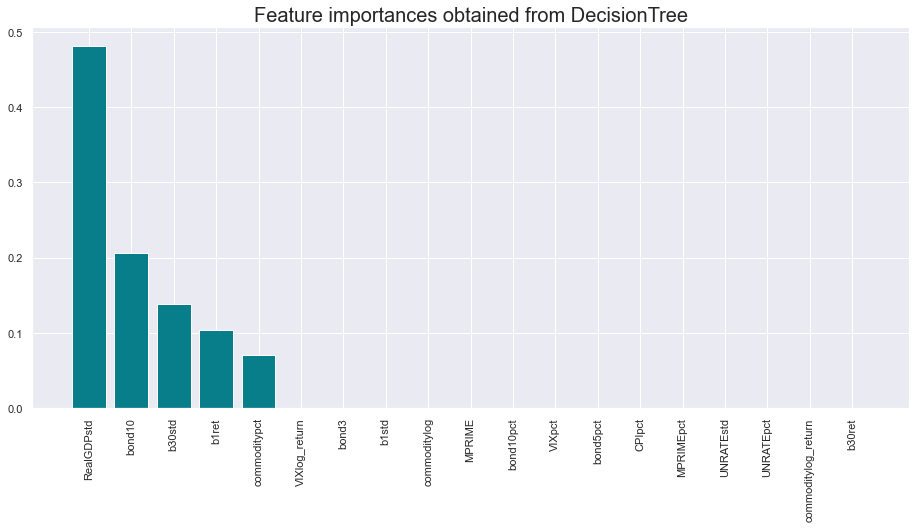

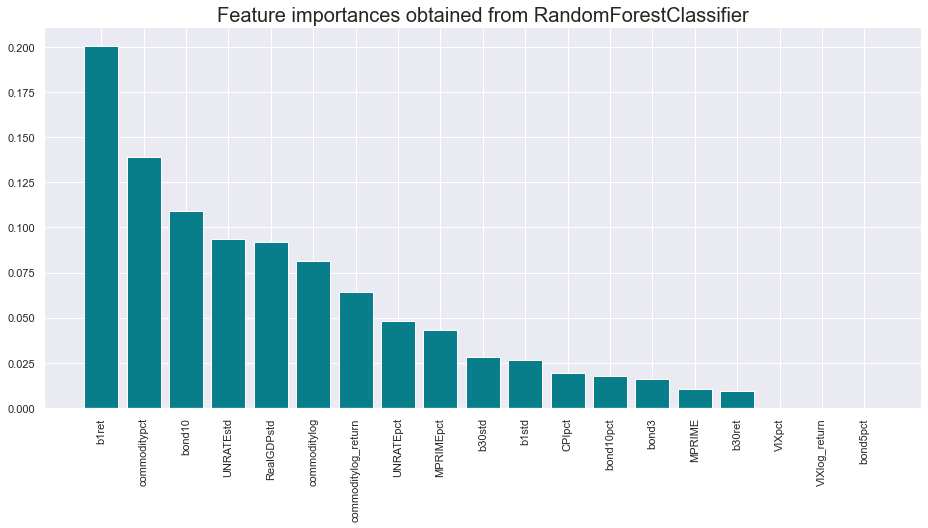

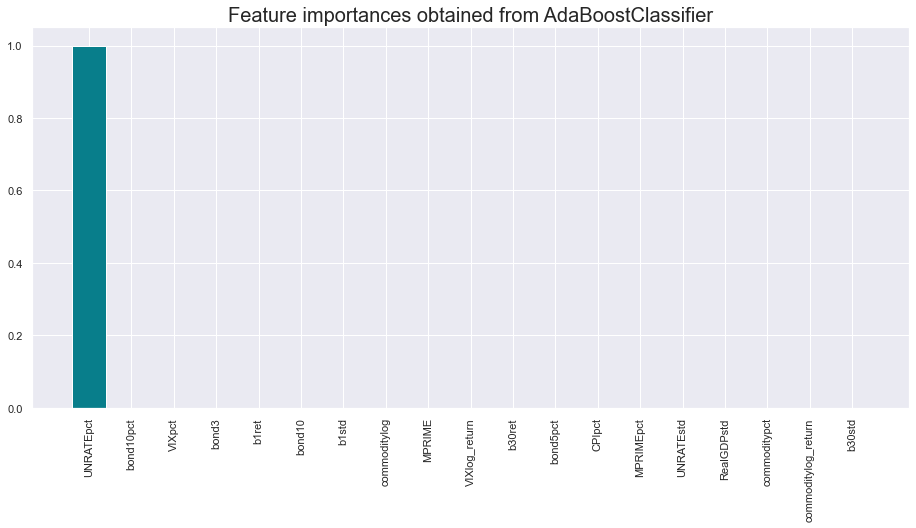

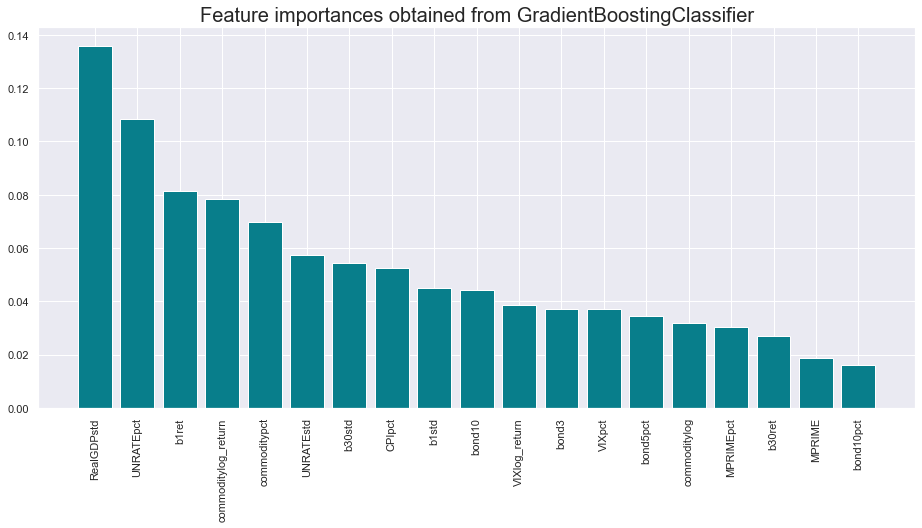

In [40]:
# feature importance
for name, _model in fitted_model.items():
    if(name == 'LinearDiscriminantAnalysis' or name == 'LogisticRegression'):
        importances = pd.DataFrame(data={'Attribute': master_pca.columns,'Importance': _model.coef_[0]})
    elif(name == 'Support Vector Machine'):
        continue
    else:
        importances = pd.DataFrame(data={'Attribute': master_pca.columns,'Importance': _model.feature_importances_})
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(14, 7))
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from '+name, size=20)
    plt.xticks(rotation='vertical')
    plt.show()

## Back Testing

In [41]:
#convert kmeans and HMM state to the same standard
# bad =0, hold = 1, long = 2
condlistK = [Kmean_state['state'] == 0, Kmean_state['state'] == 1,Kmean_state['state'] == 2]
choicelistK = [0,1,2 ]
condlistH = [HMM_state['state'] == 0, HMM_state['state'] == 1,HMM_state['state'] == 2]
choicelistH = [2,1,0 ]

Kmean_state['Kmean_Predicted'] = np.select(condlistK, choicelistK)
HMM_state['HMM_Predicted'] = np.select(condlistH, choicelistH)

In [42]:
y_monthly2['HMM_Predicted']= HMM_state['HMM_Predicted']
y_monthly2['Kmean_Predicted'] = Kmean_state['Kmean_Predicted']

In [43]:
model_name = {'LinearDiscriminantAnalysis': 'Linear',
        'LogisticRegression': 'Logistic',
        'Support Vector Machine': 'SVM',
        'DecisionTree': 'DT',
        'RandomForestClassifier': 'RF',
        'AdaBoostClassifier': 'Ada',
        'GradientBoostingClassifier':'GBDT',
        'Kmean':'Kmean',
        'HMM':'HMM'}

In [44]:
master_monthly.sort_index(ascending=True,inplace=True)

In [45]:
backtest = pd.DataFrame()
backtest["market"]=master_monthly['SP500pct'].cumsum()

In [46]:
for longname, shortname in model_name.items():
    print('start backtest ' +longname)
    backtest[shortname]=None
    backtest[shortname].iloc[0] = 0
    yname = longname+"_Predicted"
    for i in range(1,y_monthly2.shape[0]):
        if y_monthly2[yname].iloc[i] == 0:
            # short market
            backtest[shortname].iloc[i] = backtest[shortname].iloc[i-1] - master_monthly["SP500pct"].iloc[i]

        elif y_monthly2[yname].iloc[i] == 1:
            # long vix
            backtest[shortname].iloc[i] = backtest[shortname].iloc[i-1] + master_monthly["SP500pct"].iloc[i]

        else: # y_monthly2[yname].iloc[i] == 2:
            # long market
            backtest[shortname].iloc[i] = backtest[shortname].iloc[i-1] + 1.5*master_monthly["SP500pct"].iloc[i]

start backtest LinearDiscriminantAnalysis
start backtest LogisticRegression
start backtest Support Vector Machine
start backtest DecisionTree
start backtest RandomForestClassifier
start backtest AdaBoostClassifier
start backtest GradientBoostingClassifier
start backtest Kmean
start backtest HMM


<AxesSubplot:xlabel='Date'>

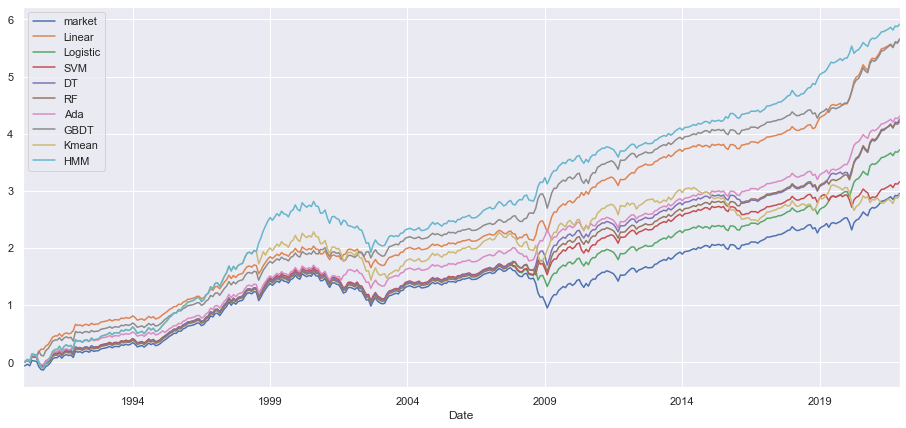

In [47]:
backtest.plot(figsize=(14,7))

In [48]:
#result of backtesting
backtest.loc['2021-12-01']

market       2.9539
Linear       5.6478
Logistic    3.71865
SVM         3.16025
DT           4.2562
RF           4.2088
Ada          4.3081
GBDT        5.66255
Kmean       2.93495
HMM         5.91865
Name: 2021-12-01 00:00:00, dtype: object

In [50]:
sharpe_ratio={}

for short in model_name.values():
    ratio = (backtest[short].iloc[-1]-backtest["market"].iloc[-1]) / backtest[short].std()
    sharpe_ratio[short] = [ratio]
    
pd.DataFrame(sharpe_ratio,index=["Sharpe_Ratio"]).T

,Sharpe_Ratio
Linear,1.974643
Logistic,0.866251
SVM,0.230165
DT,1.224969
RF,1.188220
Ada,1.251971
GBDT,1.863167
Kmean,-0.021775
HMM,1.870134
